# Aquaculture Config and Dataset Class for Mask R-CNN

This notebook subclasses the `Config` and `utils.Dataset` classes from Mask R-CNN for use with the aquaculture image dataset. 

## Setup

### Settings

In [2]:
import cv2
import os
import sys
import random
import pathlib
import math
import numpy as np
import pandas as pd
import skimage.io as skio
from scipy import ndimage
import matplotlib
import matplotlib.pyplot as plt
import copy
import shutil
from imgaug import augmenters as iaa
import datetime
%matplotlib inline

# Root directory of the project
# ROOT_DIR = os.path.abspath("/Users/Tyler-SFG/Desktop/GitHub/CropMask_RCNN")
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("notebooks/aqua"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
# from mrcnn.model import log
# from mrcnn.parallel_model import ParallelModel

Set some plotting options for visualizations.

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Project Directories

Set up paths to project directories containing prepared images (and masks), and folders to put training and testing images.

In [8]:
# Root, train, and test directories of the project
ROOT_DIR = os.path.join(ROOT_DIR, "data/aqua") # Project directory
PREPPED_DIR = os.path.join(ROOT_DIR, 'prepped_planet') # Final labeled chips and class masks
TRAIN_DIR = os.path.join(ROOT_DIR, 'train') # Train sample copied from PREPPED_DIR
TEST_DIR = os.path.join(ROOT_DIR, 'test') # Test sample copied from PREPPED_DIR
RESULTS_DIR = os.path.join(ROOT_DIR, "results") # Save submission files and test/train split csvs here

# list of directories to loop over
dirs = [TRAIN_DIR, TEST_DIR, RESULTS_DIR]

# Make directory and subdirectories
for d in dirs:
    pathlib.Path(d).mkdir(parents=True, exist_ok=True)

### Class Types

Create a dictionary of our aquaculture class types and values to use in loading masks. Likely a better solution.

In [4]:
# Class dictionary
AQUA_CLASS = {"line": 1, "raft": 2, "pond": 3, "cage": 4}

### Train/Test Split

The first step in training a model is to select a subset of the data to use for training and testing. To do so, first remove any image folders that already exist in `TRAIN_DIR` or `TEST_DIR`. Next, sample the available images in `PREPPED_DIR` and split the samples between `TRAIN_DIR` and `TEST_DIR`. 

In [9]:
import random
import shutil
random.seed(4)

def remove_dir_folders(directory):
    """
    Removes old test/train directories before a new batch of training data is created
    """
    folderlist = [ f for f in os.listdir(directory)]
    for f in folderlist:
        if not f.startswith('.'):
            shutil.rmtree(os.path.join(directory,f))

def train_test_split(prepped_dir, train_dir, test_dir, kprop):
    """Takes a sample of folder ids and copies them to a test directory. 
    each sample folder containes an images and corresponding masks folder"""
    # Remove previous training and testing data from folders
    remove_dir_folders(test_dir)
    remove_dir_folders(train_dir)

    # List of available data samples
    sample_list = next(os.walk(prepped_dir))[1]
    
    # Add training samples to training folder
    for train_sample in sample_list:
        shutil.copytree(os.path.join(prepped_dir,train_sample),os.path.join(train_dir,train_sample))

    # Sample
    k = round(kprop*len(sample_list))
    test_list = random.sample(sample_list,k)

    # Add test sample to test folder
    for test_sample in test_list:
        shutil.copytree(os.path.join(prepped_dir,test_sample),os.path.join(test_dir,test_sample))
    
    train_list = list(set(next(os.walk(train_dir))[1]) - set(test_list))
    
    # Save csvs of result files
    train_df = pd.DataFrame({'train': train_list})
    test_df = pd.DataFrame({'test': test_list})
    train_df.to_csv(os.path.join(RESULTS_DIR, 'train_ids.csv'))
    test_df.to_csv(os.path.join(RESULTS_DIR, 'test_ids.csv'))

# Run function
train_test_split(PREPPED_DIR, TRAIN_DIR, TEST_DIR, 0.2)

## Aquaculture Config Class

## Aquaculture Dataset Class

In [17]:
class AquaDataset(utils.Dataset):
    """Generates the Imagery dataset."""
    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,4] Numpy array.
        Channels are ordered [B, G, R, NIR]. This is called by the 
        Keras data_generator function
        """
        # Load image
        image = skio.imread(self.image_info[image_id]['path'])
    
        assert image.shape[-1] == 4
        assert image.ndim == 3
    
        return image
    
    def load_aqua(self, dataset_dir, subset):
        """Load a subset of the aquaculture dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load.
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have four classes.
        # Naming the dataset aqua, and the class agriculture
        self.add_class("aqua", 1, "line")
        self.add_class("aqua", 2, "raft")
        self.add_class("aqua", 3, "pond")
        self.add_class("aqua", 4, "cage")

        assert subset in ["train", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        train_ids = pd.read_csv(os.path.join(RESULTS_DIR, 'train_ids.csv'))
        train_list = list(train_ids['train'])
        test_ids = pd.read_csv(os.path.join(RESULTS_DIR, 'test_ids.csv'))
        test_list = list(test_ids['test'])
        
        # Set image ids based on subset
        if subset == "test":
            image_ids = test_list
        else:
            image_ids = train_list
        
        # Add images
        for image_id in image_ids:
            self.add_image(
                "aqua",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "image/{}.tif".format(image_id)))
       
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        
        # Get class mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "class_masks")

        # Read class mask files from .png image
        mask = [] # array to store instance masks
        classes = [] # array to store instance class 
        
        # Loop over class mask files
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith(".tif"):                
                
                # Read class mask
                m = skio.imread(os.path.join(mask_dir, f)).astype(np.bool)
                
                # Get class of instance mask from file name
                instance_class = f.split('_')[5]            
                                
                # Label objects in mask and save labeled image as "labels" and number of objects as "nb"
                labels, nb = ndimage.label(m)
                
                # Loob over labeled objects and isolate instance mask
                for obj in range(1,nb+1):
                    # Make new object from labels
                    instance = labels * 1
                    # Replace all other objects with 0s
                    instance[labels!=obj] = 0
                    # Set object values to 1 (rather than object id number)
                    instance[labels==obj] = 1

                    # Add instance mask to mask array
                    mask.append(m)
                    classes.append(AQUA_CLASS[instance_class])
                    assert m.ndim == 2        
        
        # Check if mask is still empty and, if so, add a np array of zeros
        if not mask:
            m = np.zeros([256, 256], dtype=np.uint8)
            mask.append(m)
            
        mask = np.stack(mask, axis=-1)
        assert mask.ndim == 3
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "field":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

## Display Dataset

Load the dataset and display random samples to check if dataset has been created properly.

In [19]:
# Create training dataset
dataset_train = AquaDataset()
dataset_train.load_aqua(ROOT_DIR, "train")
dataset_train.prepare()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


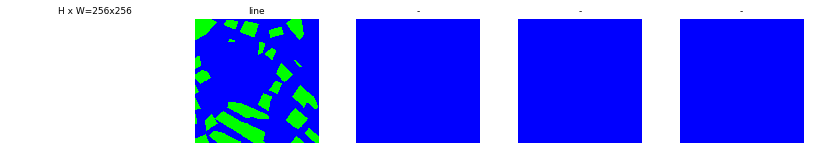

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


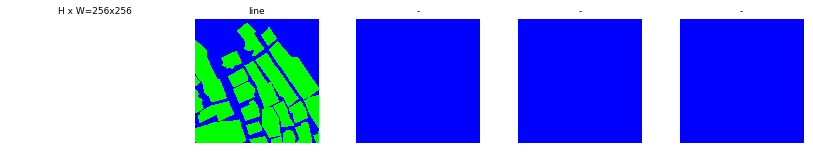

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


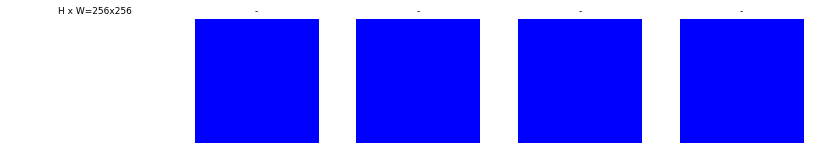

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


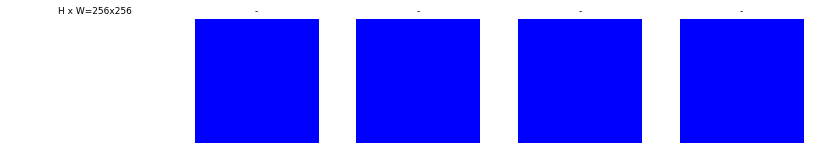

In [23]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)